In [28]:
import Logging: global_logger
import TerminalLoggers: TerminalLogger
global_logger(TerminalLogger())

TerminalLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(54) open, 0 bytes waiting))), LogLevel(-1), TerminalLoggers.default_metafmt, true, 0, false, 0, Dict{Any, Int64}(), TerminalLoggers.StickyMessages(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(54) open, 0 bytes waiting))), false, Pair{Any, String}[]), LeftChildRightSiblingTrees.Node{TerminalLoggers.ProgressBar}[], ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), SpinLock(0)), (0, 0, 0)))

In [29]:
using ModelingToolkit 
using DomainSets
using MethodOfLines
using NonlinearSolve
using DifferentialEquations
include("multiharmonic_balance.jl");
using Random
using Base.Threads
using LinearSolve
using IncompleteLU

# Plotting
using Plots

# FFTW 
using FFTW

In [3]:
xleft::Float64 = 0.0;
xright::Float64 = 1.0;
t0::Float64 = 0.0;
T::Float64 = 200.0;
Nx::Int64 = N = 200;
stepx = (xright - xleft)/Nx;
L = xright - xleft;
dt = 1e-3
Nt::Int64 = (T - t0)/dt;
grid = collect(xleft:stepx:xright);

#Definition of constants specific to the equation (Wave Equation) (placeholders):
gamma = 0.0;
gamma3_final = 0.0;

g0::Float64 = 1; # m / s^2
height = 1; # m
harmonics = 3; # number of harmonics
A_forcing::Float64 = 20.0
lambda_forcing::Float64 = -40;
omega = 2π * 1;

#Define parameters and variables
@parameters x y t
@variables u_FD(..)

#Define differential operators:
const Dt = Differential(t);
const Dx = Differential(x);
const Dy = Model.Differential(y)
const Dtt = Differential(t)^2;
const Dxx = Differential(x)^2;

In [24]:
function f1!(dv, v, u, p, t)
    dx, c, γ, γ3, A, omega, lambda = p
    N = length(u)
    invdx2 = 1 / dx^2

    # interior points
    @inbounds for i in 2:N-1
        uxx = (u[i+1] - 2u[i] + u[i-1]) * invdx2
        dv[i] = c^2 * uxx - γ * v[i] - γ3 * v[i]^3 + A * exp(lambda * ((i - 1) * dx)^2) * sin(omega * t)
    end
    dv[1] = 0
    dv[end] = 0
    

end


function f2!(du, v, u, p, t)
    dx, c, γ, γ3, A, omega = p
    N = length(u)
    du .= v
    du[1] = 0
    du[end] = 0
end

u0 = zeros(Nx+1)
v0 = zeros(Nx+1)

tspan = (0.0, T)
p = (stepx, sqrt(g0 * height), gamma, gamma3_final, A_forcing, omega, lambda_forcing)

prob = DynamicalODEProblem(f1!, f2!, u0, v0, tspan, p)
solution = solve(prob, VelocityVerlet(), reltol = 1e-8, abstol = 1e-8, dt = 0.001, saveat=0.01);

U = hcat([sol.x[2] for sol in solution.u]...)
sol_u = U
println(size(sol_u))
discrete_t = solution.t



(201, 20001)


20001-element Vector{Float64}:
   0.0
   0.01
   0.02
   0.03
   0.04
   0.05
   0.06
   0.07
   0.08
   0.09
   0.1
   0.11
   0.12
   ⋮
 199.89
 199.9
 199.91
 199.92
 199.93
 199.94
 199.95
 199.96
 199.97
 199.98
 199.99
 200.0

## Visualization FD

In [ ]:
# Create the animation object
anim = @animate for k in 18000:20000
    t = discrete_t[k]
    plot(
        grid, sol_u[:, k],
        ylim = (-5.0, 5.0),
        xlabel = "x",
        ylabel = "u(x, t)",
        title = "t = $(round(t, digits=2))",
        legend = false
    )
end

# Save the animation as a GIF
gif(anim, "solution_animation_1.gif", fps = 60)

# Harmonic Balance

In [9]:
function make_WaveEquation_1D(u_HB, g0, height, gamma, gamma3, forcing)
            
    pde::Symbolics.Num = Dt(Dt(u_HB)) - g0*height*(Dx(Dx(u_HB))) + gamma*Dt(u_HB) + gamma3*Dt(u_HB)*Dt(u_HB)*Dt(u_HB) - forcing;

    return pde
end;

In [11]:
u0 = rand((Nx + 1) * harmonics * 2)*7;
solHB = nothing 
u_hist = Vector{Float64}[]  # store history for prediction
gamma3_hist = Float64[]


vars, var_exprs, (u_HB,) = create_ansatz((x,), t, omega, harmonics);
    
forcing = A_forcing * exp(lambda_forcing*x^2) * sin(omega * t)

bc_conds = Dict(
    :A1 => [:(0.0), 0.0],
    :B1 => [:(0.0), 0.0],
    :A2 => [:(0.0), 0.0],
    :B2 => [:(0.0), 0.0],
    :A3 => [:(0.0), 0.0],
    :B3 => [:(0.0), 0.0],
)

gamma3 = 0.0
dgamma3 = 0.01
resid = nothing

while gamma3 < gamma3_final
    timed_out = false
    println("Beginning the symbolics manipulation")
    flush(stdout)
    
    if length(u_hist) >= 2
        u0 = u_hist[end] + (u_hist[end] - u_hist[end-1]) * 
             dgamma3 / (gamma3_hist[end] - gamma3_hist[end-1])
    elseif length(u_hist) == 1
        u0 = u_hist[end]
    else
        u0 = rand((Nx+1) * harmonics * 2)*.3
    end
    
    
    pde = make_WaveEquation_1D(u_HB, g0, height, gamma, gamma3, forcing);
    

    expanded = expand_trig_jl(pde, t, omega)
    eqns = make_equations(expanded, harmonics, omega, t)
    sym_eqs = map(transform_sym(Nx,) ∘ Meta.parse ∘ string, eqns)
    
    resid = create_residual_function(sym_eqs, vars, Nx, 0, bc_conds);
    
    residual! = eval(resid)
    
    DiffMat, LaplCoeff = create_jac_blocks(eqns, var_exprs, harmonics)
    jacobian! = create_jacobian_function(Nx + 1, DiffMat, LaplCoeff, harmonics)
    
    # Create prototype by calling jacobian! once with dummy sparse matrix
    n = (Nx + 1) * harmonics * 2
    jac_prototype = spzeros(n, n)
    jacobian!(jac_prototype, u0, [stepx])
    
    func = NonlinearFunction(residual!; jac = jacobian!, jac_prototype = jac_prototype)
    prob = NonlinearProblem(func, u0, [stepx])
    
    solHB = solve(prob, TrustRegion(linsolve = KLUFactorization()), reltol=1e-5, abstol=1e-5, maxiters=1000)
    
    u0 = solHB.u
    println(round(gamma3, sigdigits=6), " ", solHB.retcode)
    if solHB.retcode == ReturnCode.Success
        println("Succeeded!")
        flush(stdout)
        push!(u_hist, copy(solHB.u))
        push!(gamma3_hist, gamma3)
        dgamma3 = min(dgamma3 * 1.2, 0.02)
        
        gamma3 += dgamma3

        if gamma3 > gamma3_final
            gamma3 = gamma3_final
            break
        end
        
    else
        println("Failed! Going back to the previous gamma and reducing the step!")
        flush(stdout)
        dgamma3 = min(dgamma3 * 1.2, 0.005)
        gamma3 += dgamma3
        # dgamma3 /= 10
        # gamma3 += dgamma3
        dgamma3 < 1e-6 && break
    end


    
end

pde = make_WaveEquation_1D(u_HB, g0, height, gamma, gamma3, forcing);
    
expanded = expand_trig_jl(pde, t, omega)
eqns = make_equations(expanded, harmonics, omega, t)
sym_eqs = map(transform_sym(Nx,) ∘ Meta.parse ∘ string, eqns)

resid = create_residual_function(sym_eqs, vars, Nx, 0, bc_conds);

residual! = eval(resid)

DiffMat, LaplCoeff = create_jac_blocks(eqns, var_exprs, harmonics)
jacobian! = create_jacobian_function(Nx + 1, DiffMat, LaplCoeff, harmonics)

# Create prototype by calling jacobian! once with dummy sparse matrix
n = (Nx + 1) * harmonics * 2
jac_prototype = spzeros(n, n)
jacobian!(jac_prototype, u0, [stepx])  # fills in the pattern

func = NonlinearFunction(residual!; jac = jacobian!, jac_prototype = jac_prototype)
prob = NonlinearProblem(func, u0, [stepx])

@time solHB = solve(prob, NewtonRaphson(linsolve = KLUFactorization()), reltol=1e-5, abstol=1e-5, maxiters=1000)


print(solHB.retcode)

coefficientsHB = [reshape(solHB.u[(k-1)*(Nx + 1)+1:k*(Nx + 1)], Nx+1) for k in 1:(2*harmonics)];

  0.437072 seconds (1.98 M allocations: 106.489 MiB, 7.11% gc time, 98.42% compilation time)
Success

## Visualization HB

In [ ]:
anim = @animate for t in 1:0.01:10
    if t % 100 == 0
        println(t)
    end
    u_new = zeros(length(grid))
        j = 1
        for i in 1:(2*harmonics)
            if isodd(i)
                u_new .+= coefficientsHB[i] .* sin(j * omega * t)
            else
                u_new .+= coefficientsHB[i] .* cos(j * omega * t)
                j += 1
            end
        end
    plot(u_new)
    title!("Wave Equation with H = $(harmonics), \$\\gamma\$ = $(gamma), \$\\gamma_3\$ = $(gamma3_final), \$\\omega\$ = $omega", titlefontsize=10)
    ylims!(-0.02, 0.02)
end

gif(anim, "HB_WE_1D.gif", fps=60)

# Fourier Transform Comparison

In [25]:
t_steady0 = 19000
x_points = size(sol_u)[1]
spatial_grid = 1:x_points
coeffs::Vector{Vector{Float64}} = []
fs_time = fs = 1/0.01

#Finding amplitude at specific frequency
for h in 1:harmonics
    target = h * omega / (2 * pi)
    println("new target: ", target)
    push!(coeffs, spatial_grid |> length |> zeros)
    push!(coeffs, spatial_grid |> length |> zeros)
    for point_idx in 1:1:x_points
        u_at_point = sol_u[point_idx, t_steady0:end]
        F = fftshift(fft(u_at_point))
        freqs = fftshift(fftfreq(length(u_at_point), fs_time))
        (_, idx) = findmin(abs.(freqs .- target))
        #println(idx, ", ", F[idx], ", ", -2*imag(F[idx]), ", ", 2*real(F[idx]), ", ", target)
        coeffs[2 * h - 1][point_idx] = -2*real(F[idx])*(1/(size(sol_u)[2] - t_steady0)) # sin
        coeffs[2 * h][point_idx] = -2*imag(F[idx])*(1/(size(sol_u)[2] - t_steady0)) # cos
    end
end

new target: 1.0
new target: 2.0
new target: 3.0


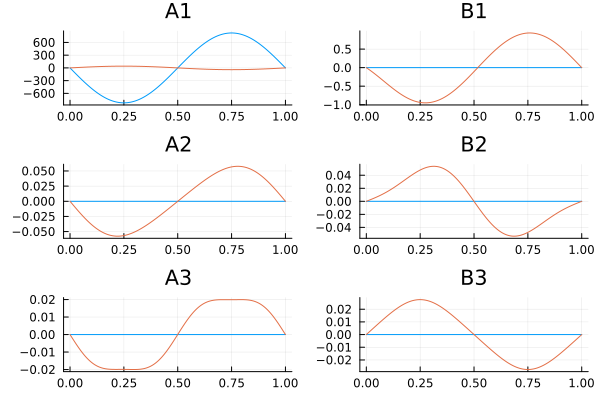

In [26]:
plots = Vector{Plots.Plot}(undef, 2 * harmonics)

for i in 1:(2*harmonics)
    title = ""
    if i % 2 == 1
        title = string("A", div(i + 1, 2))
    else
        title = string("B", div(i, 2))
    end
    p = plot(xleft:stepx:xright, coefficientsHB[i]; title = title, label="HB Coeff") 
    plot!(p, xleft:stepx:xright, coeffs[i];label="FD coeff")
    plots[i] = p
end

plot(plots...; layout=(harmonics, 2), legend=false)

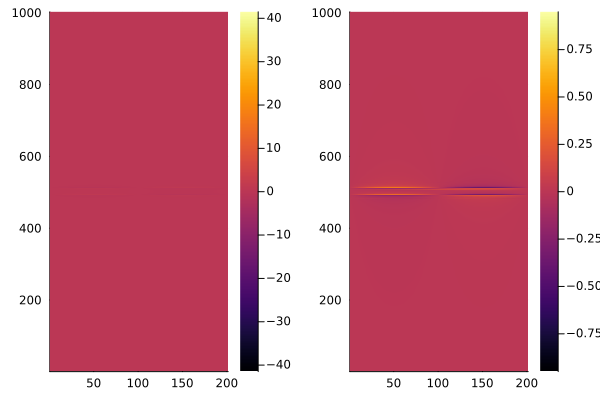

In [27]:
function generateSpectrumMatrix()
    r1 = []
    r2 = []
    rows = 0
    for point_idx in 1:1:x_points
        u_at_point = sol_u[point_idx, t_steady0:end]
        F = fftshift(fft(u_at_point))
        freqs = fftshift(fftfreq(length(u_at_point), fs_time))
        rows = length(freqs)

        push!(r1, (-2 .* real.(F) .* (1/(size(sol_u)[2] - t_steady0)))...)
        push!(r2, (-2 .* imag.(F) .* (1/(size(sol_u)[2] - t_steady0)))...)
        

        # (_, idx) = findmin(abs.(freqs .- target))
        # #println(idx, ", ", F[idx], ", ", -2*imag(F[idx]), ", ", 2*real(F[idx]), ", ", target)
        # coeffs[2 * h - 1][point_idx] = -2*real(F[idx])*(1/(size(sol_u)[2] - t_steady0)) # sin
        # coeffs[2 * h][point_idx] = -2*imag(F[idx])*(1/(size(sol_u)[2] - t_steady0)) # cos
        
    end
    res1 = reshape(r1, (rows, div(length(r1), rows)))
    res2 = reshape(r2, (rows, div(length(r2), rows)))
    res1, res2
end
sins, coses = generateSpectrumMatrix()
plot(heatmap(sins), heatmap(coses); layout = (1, 2))